In [29]:
import os

datadir = "/home/ymerel/fmri/OHBM_2026_neurovariants/data/emotion_1000"
ds_path = os.path.join(datadir, 'dataset.csv')
corr_path = os.path.join(datadir, 'correlations.csv')
corr_func = 'pearson'
basedir = "/home/ymerel/storage/results/"
jobname = "emotion_1000"
result_path = f"{basedir}{jobname}"
coords = [-20, -6, -16]

In [30]:
!sshfs -o reconnect,ServerAliveInterval=120,ServerAliveCountMax=3 rennes.g5k:/srv/storage/empenn@storage2.rennes.grid5000.fr/private/ymerel /home/ymerel/storage

fusermount3: failed to access mountpoint /home/ymerel/storage: Permission denied


In [31]:
import pandas as pd

def normalize_dataset(ds: pd.DataFrame):
    
    str_alternatives = {
        "motion_correction_realignment/register_to" : ["first", "mean"],
        "coregistration/source_target" : ["anat_on_func", "func_on_anat"],
        "coregistration/cost_function" : ["mutual_information", "normalised_mutual_information", "entropy_correlation_coefficient", "normalised_cross_correlation"],
        "spatial_normalization/template" : ["Ixi549Space", "MNI305", "MNI152_linear", "MNI152_nonlinear"],
        "spatial_normalization/algorithm" : ["linear", "nonlinear", "DARTEL"],
        "spatial_normalization/interpolation" : ["nearest_neighbour", "trilinear", "bspline"],
        "slice_timing_correction/ref_slice" : ["first", "middle"],
        "signal_modeling/hrf" : ["canonical", "temporal_derivs", "temporal_dispersion_derivs"],
        "signal_modelling/temporal_noise_autocorrelation" : ["AR1", "FAST"],
    }

    num_alternatives = {
        "spatial_normalization/bias_fwhm" : [30, 40, 60, 70, 80, 90, 100, 110, 120,130,140,150],
        "spatial_smoothing/fwhm" : [2, 4, 6, 8, 10, 12, 14],
        "signal_modeling/nuisance_regressors/motion" : [6, 18, 24]
    }
    
    bias_regs = {
            'extremely_light': 0.00001,
            'very_light': 0.0001,
            'light': 0.001,
            'medium': 0.01,
            'heavy': 0.1
        }
    
    # change column types
    for col in num_alternatives:
        ds[col] = ds[col].astype(int)
    for col in bias_regs:
        ds[f"spatial_normalization/bias_regularisation/{col}"] = ds[f"spatial_normalization/bias_regularisation/{col}"].astype(float)
    
    for index, row in ds.iterrows():
        for feature, values in num_alternatives.items():
            if row[feature] is False:
                ds.at[index, feature] = 0
                continue
            for val in values:
                alt = f"{feature}/{val}"
                if row[alt] is True:
                    ds.at[index, feature] = val
        for label, value in bias_regs.items():
            if row[f"spatial_normalization/bias_regularisation/{label}"] is True:
                ds.at[index, "spatial_normalization/bias_regularisation"] = value
    
    for key in num_alternatives:
        for val in num_alternatives[key]:
            ds = ds.drop(f"{key}/{val}",  axis=1)
    ds = ds.convert_dtypes()
    boolean_columns = ds.select_dtypes(include='bool').columns
    columns_to_drop = [col for col in boolean_columns if ds[col].all()]
    columns_to_drop.append("pearson_from_mean")
    columns_to_drop.append("spearman_from_mean")
    columns_to_drop.append("spearman_from_ref")
    ds = ds.drop(columns=columns_to_drop)
    ds.rename(columns={f'{corr_func}_from_ref': 'from_ref'}, inplace=True)
    return ds

# Load data

In [32]:
# load correlations

dataset = pd.read_csv(ds_path, delimiter=';')

ids_to_exclude = dataset.loc[dataset['coregistration/source_target/anat_on_func'] == False, 'id'].unique()
print(f"Excluding {len(ids_to_exclude)}")

dataset = dataset[~dataset['id'].isin(ids_to_exclude)].copy()
dataset = normalize_dataset(dataset)

print(f"{len(dataset)} configs in dataset")

correlations = pd.read_csv(corr_path, delimiter=';')
correlations = correlations[
    (~correlations['source'].isin(ids_to_exclude)) &
    (~correlations['target'].isin(ids_to_exclude))
].copy()
print(f"{len(correlations)} correlations in matrix")
matrix = correlations.pivot(index='source', columns='target', values=corr_func).fillna(1.0)
distance_matrix = 1 - matrix

dataset.head(1010)

Excluding 496
504 configs in dataset
256036 correlations in matrix


,coregistration/source_target/func_on_anat,signal_modeling/nuisance_regressors,motion_correction_realignment/register_to/mean,coregistration/cost_function/normalised_mutual_information,motion_correction_realignment/register_to/first,signal_modelling/temporal_noise_autocorrelation/FAST,spatial_normalization/template/MNI152_linear,spatial_normalization/interpolation/trilinear,spatial_normalization/template/MNI305,spatial_normalization/algorithm/linear,...,signal_modeling/hrf/temporal_dispersion_derivs,slice_timing_correction/tool,spatial_normalization/interpolation/bspline,spatial_normalization/bias_regularisation/heavy,slice_timing_correction,slice_timing_correction/tool/spm,slice_timing_correction/ref_slice/first,spatial_normalization/template/MNI152_nonlinear,id,from_ref
0,False,True,True,True,False,False,False,False,False,False,...,False,True,True,0,True,True,False,False,3c05066eec67a15033be163c0f9ff11b5c10fd45cd65ba...,0.900965
1,False,True,True,True,False,False,False,True,False,False,...,False,True,False,0,True,True,True,False,6a45076ef4e7d5e2e19b1eff4c2400f12820aff5f5de35...,0.962165
2,False,True,True,False,False,True,False,True,False,False,...,True,True,False,0,True,True,True,False,a81f94290b1b4f571a07d9b91a109579ee7d03659cdf52...,0.941414
8,False,True,True,False,False,False,False,False,False,False,...,True,True,False,0,True,True,True,False,c3c520e2c2781f0e10728b82df5d0e3f5d6c65bf592a12...,0.921726
10,False,False,True,False,False,True,False,False,False,False,...,False,True,False,0,True,True,False,False,8a9797201a7882a865c896385904f67dd9071401da65ca...,0.400968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,False,False,True,False,False,False,False,False,False,False,...,False,False,True,0,False,False,False,False,a90811473fc32c042f2784233b083de79e1cccd2593cb4...,0.407764
992,False,True,False,False,True,False,False,False,False,False,...,False,False,True,0,False,False,False,False,2d86e12fdef806e5e9310ef362ea3ddd1096b337714568...,0.889477
996,False,True,True,False,False,False,False,False,False,False,...,False,False,True,0,False,False,False,False,59f2ff57b0b98f94f4fa0c8ca60f1825d2dc4e36c726e1...,0.470753
997,False,False,False,False,True,False,False,False,False,False,...,True,True,True,0,True,True,True,False,b113529b25ad5d523e71aa871814dd6488422ed4e99bcd...,0.788285


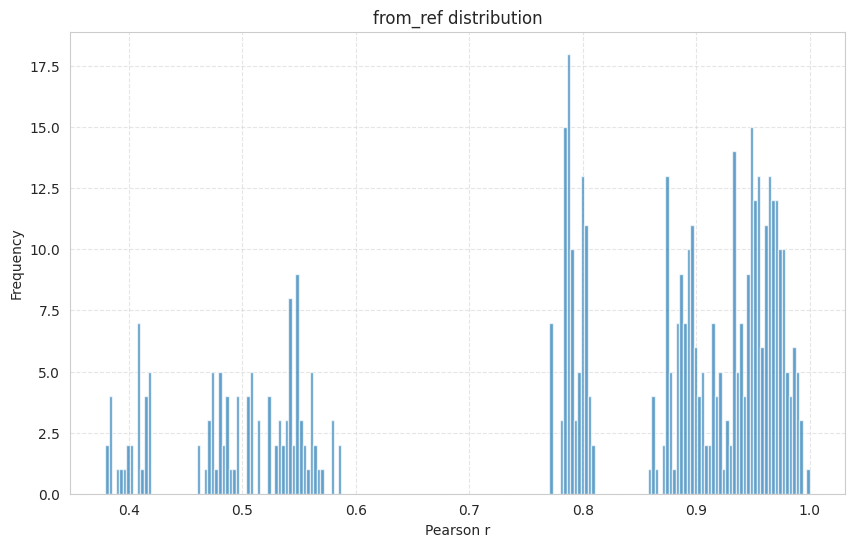

/home/ymerel/tmp/ipykernel_48689/3804470831.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sb.kdeplot(dataset['from_ref'], shade=True, color='blue')


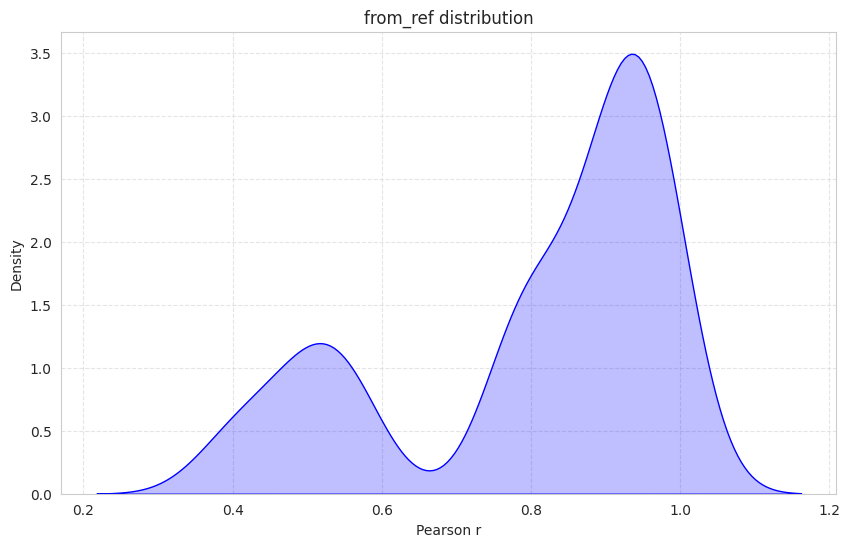

In [33]:
import seaborn as sb
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(dataset['from_ref'], bins=200, alpha=0.7)
plt.title('from_ref distribution')
plt.xlabel('Pearson r')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(10, 6))
sb.kdeplot(dataset['from_ref'], shade=True, color='blue')
plt.title('from_ref distribution')
plt.xlabel('Pearson r')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Compare correlations metrics
Evaluate distribution of values for Pearson, spearman, jaccard, dice
Compare Pearson vs Spearman

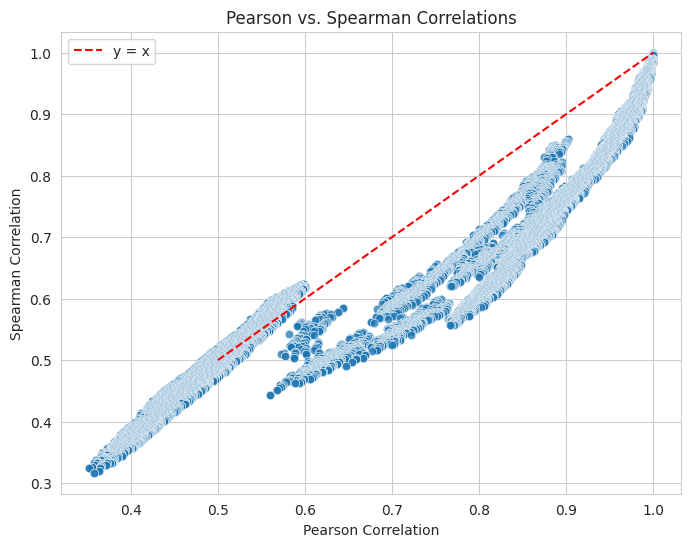

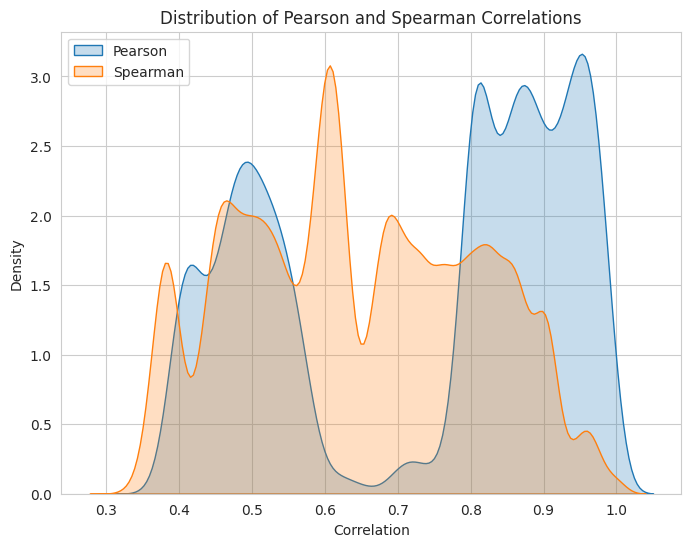

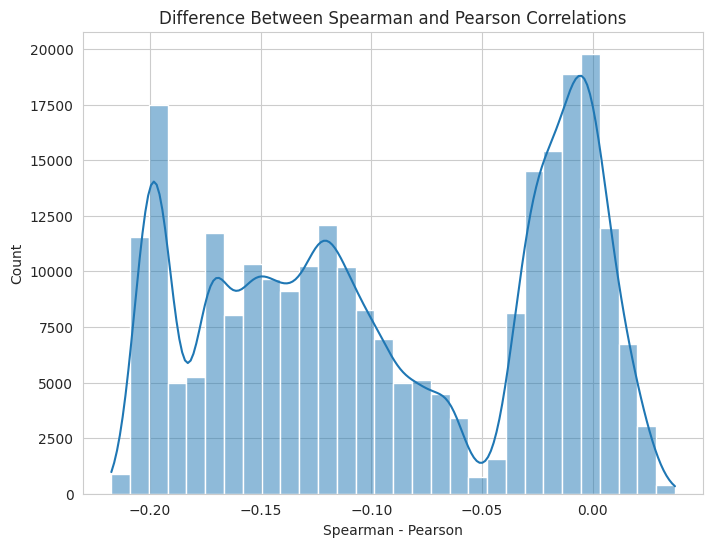

In [34]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize=(8, 6))
sb.scatterplot(data=correlations, x="pearson", y="spearman", alpha=0.5)
plt.plot([0.5, 1], [0.5, 1], 'r--', label="y = x")  # Diagonal line
plt.xlabel("Pearson Correlation")
plt.ylabel("Spearman Correlation")
plt.title("Pearson vs. Spearman Correlations")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sb.kdeplot(data=correlations, x="pearson", label="Pearson", fill=True)
sb.kdeplot(data=correlations, x="spearman", label="Spearman", fill=True)
plt.xlabel("Correlation")
plt.ylabel("Density")
plt.title("Distribution of Pearson and Spearman Correlations")
plt.legend()
plt.show()

correlations["difference"] = correlations["spearman"] - correlations["pearson"]

plt.figure(figsize=(8, 6))
sb.histplot(data=correlations, x="difference", bins=30, kde=True)
plt.xlabel("Spearman - Pearson")
plt.ylabel("Count")
plt.title("Difference Between Spearman and Pearson Correlations")
plt.show()

# Clusterize

## Cluster by threshold

In [35]:
from utils import clusterize_hierch, predict_clusters, get_cluster_distance_densities, get_cluster_cophenetic,get_cluster_silhouette, get_cluster_inertia, get_davies_bouldin, get_medoids, get_antimedoids
import numpy as np

all_results = []

thresholds = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in thresholds:
    results = dict()
    results['threshold'] = threshold
    # cluster on whole dataset
    ds, matrix, Z, clusters = clusterize_hierch(dataset, correlations, dataset['id'], None, corr_func, threshold)
    results['clusters'] = len(np.unique(clusters.values))
    
    distance_matrix = 1 - matrix
    densities = get_cluster_distance_densities(distance_matrix.values, clusters.values)
    results['mean_density'] = np.mean(list(densities.values()))
    results['cophenetic'] = get_cluster_cophenetic(Z, distance_matrix.values)
    results['silhouette'] = get_cluster_silhouette(distance_matrix.values, clusters.values)
    results['davies_bouldin'] = get_davies_bouldin(distance_matrix.values, clusters.values)
    results['inertia'] = get_cluster_inertia(distance_matrix.values, clusters.values)
    results['medoids'] = get_medoids(distance_matrix, clusters)
    results['antimedoids'] = get_antimedoids(distance_matrix, clusters)
    # predict on 70 % train dataset
    merged_results = results | predict_clusters(dataset, correlations, None, corr_func, threshold, 0.7)
    all_results.append(merged_results)
df_by_thresh = pd.DataFrame(all_results)

/home/ymerel/fmri/OHBM_2026_neurovariants/utils.py:110: RuntimeWarning: invalid value encountered in scalar divide
  avg_dist = (np.sum(cluster_dist) - np.sum(np.diag(cluster_dist))) / (cluster_dist.size - len(cluster_dist))


## Print all metrics
- Cophenetic correlation: > 0.75 = good ; < 0.75 = poor
- Silhouette score: -1 = worst ; 1 = best
- Davies-Bouldin index: < 1 = good
- Inertia: lower = tighter

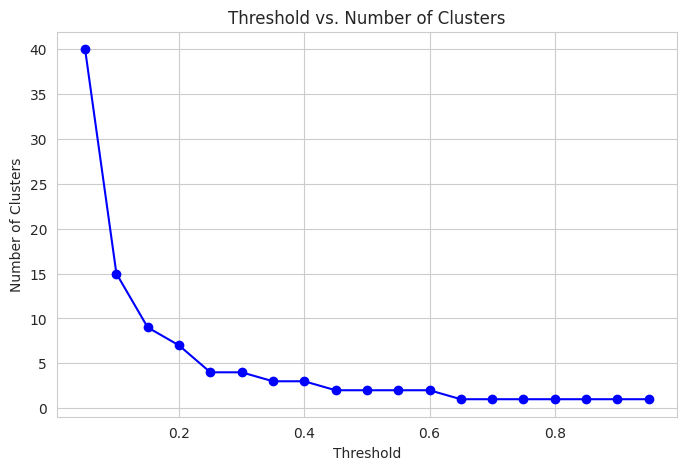

,threshold,clusters,mean_density,cophenetic,silhouette,davies_bouldin,inertia,medoids,antimedoids,train_size,accuracy,recall,decision_tree,feature_importances
0,0.05,40,NaN,0.980708,0.538327,0.832142,10.218845,{7: '8e7a3fb09a6004de3f0afe2851c25be3282d4b51f...,{7: '73f58b4b40fd50331130902dbdf5c93307cb88890...,0.7,0.934211,0.797297,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.1080...
1,0.10,15,0.033779,0.980708,0.563003,0.744597,63.990760,{2: 'b10ba27b41c72cecd805fe36c225741ff4fd50f1f...,{2: 'f16d9fe0be02758f93babb75adea3d1ecb0129bc9...,0.7,0.980263,0.928571,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/me...
2,0.15,9,0.045602,0.980708,0.637094,0.529190,145.484600,{2: 'b10ba27b41c72cecd805fe36c225741ff4fd50f1f...,{2: '3a9f642fc69e25b0249c29200e88afa8956cd7285...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/fi...
3,0.20,7,0.060463,0.980708,0.614884,0.544137,637.828292,{1: '39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c...,{1: '8b0536ff1f27f2ac4767ba4a610e6b6acaf3f3193...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.3423...
4,0.25,4,0.104430,0.980708,0.690986,0.669456,2379.408475,{1: '63669d11fdc934c5bd51d71bcfbdcf8bd57e1f9d8...,{1: '71515e9aa18d9e5a3982b2c804496dc4317fe6c56...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors/motion':...
5,0.30,4,0.104430,0.980708,0.690986,0.669456,2379.408475,{1: '63669d11fdc934c5bd51d71bcfbdcf8bd57e1f9d8...,{1: '71515e9aa18d9e5a3982b2c804496dc4317fe6c56...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors/motion':...
6,0.35,3,0.116882,0.980708,0.703823,0.476230,2564.848245,{1: '63669d11fdc934c5bd51d71bcfbdcf8bd57e1f9d8...,{1: '71515e9aa18d9e5a3982b2c804496dc4317fe6c56...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors/motion':...
7,0.40,3,0.116882,0.980708,0.703823,0.476230,2564.848245,{1: '63669d11fdc934c5bd51d71bcfbdcf8bd57e1f9d8...,{1: '71515e9aa18d9e5a3982b2c804496dc4317fe6c56...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors/motion':...
8,0.45,2,0.157147,0.980708,0.742386,0.299314,3072.698422,{1: '63669d11fdc934c5bd51d71bcfbdcf8bd57e1f9d8...,{1: '71515e9aa18d9e5a3982b2c804496dc4317fe6c56...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/normalised_cros...
9,0.50,2,0.157147,0.980708,0.742386,0.299314,3072.698422,{1: '63669d11fdc934c5bd51d71bcfbdcf8bd57e1f9d8...,{1: '71515e9aa18d9e5a3982b2c804496dc4317fe6c56...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/normalised_cros...


In [36]:
df_results = df_by_thresh
plt.figure(figsize=(8, 5))
plt.plot(df_results['threshold'], df_results['clusters'], marker='o', linestyle='-', color='b')
plt.title('Threshold vs. Number of Clusters')
plt.xlabel('Threshold')
plt.ylabel('Number of Clusters')
plt.grid(True)
plt.show()
df_results.head(20)

## Identify incorrect clusters by medoids

Cluster [1] - Medoid [39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c71c82f4258bb4e2aac593f0]


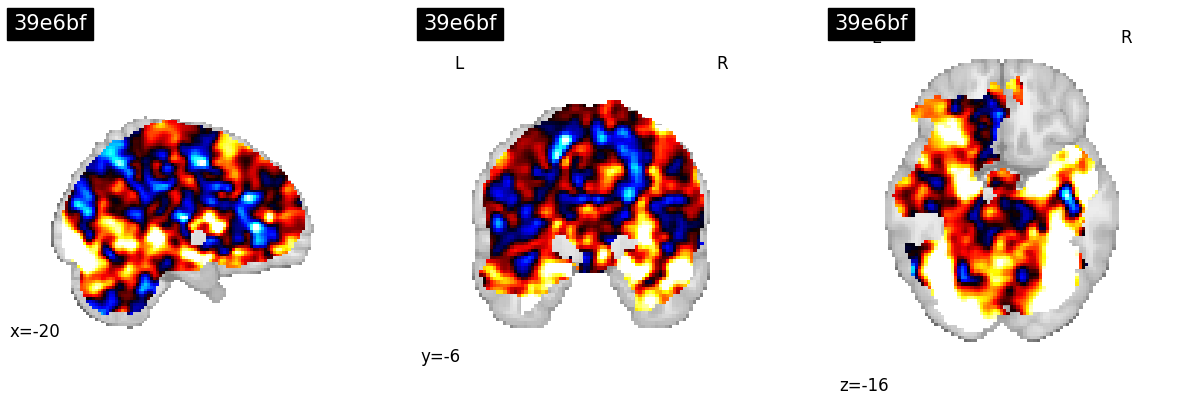

Cluster [1] - Antimedoid


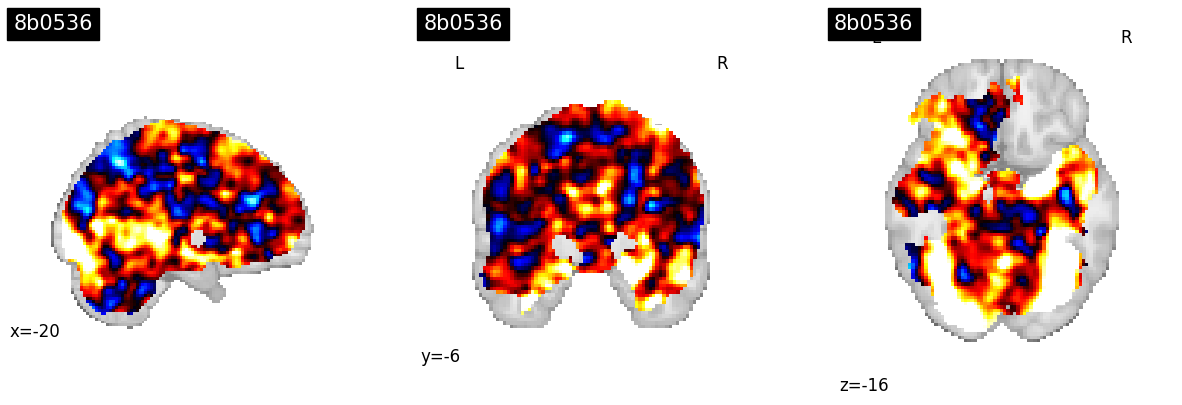

Cluster [2] - Medoid [175aba5e213089daa24c32d5cb3c34193538db2a394fe7956eec838c924b11d5]


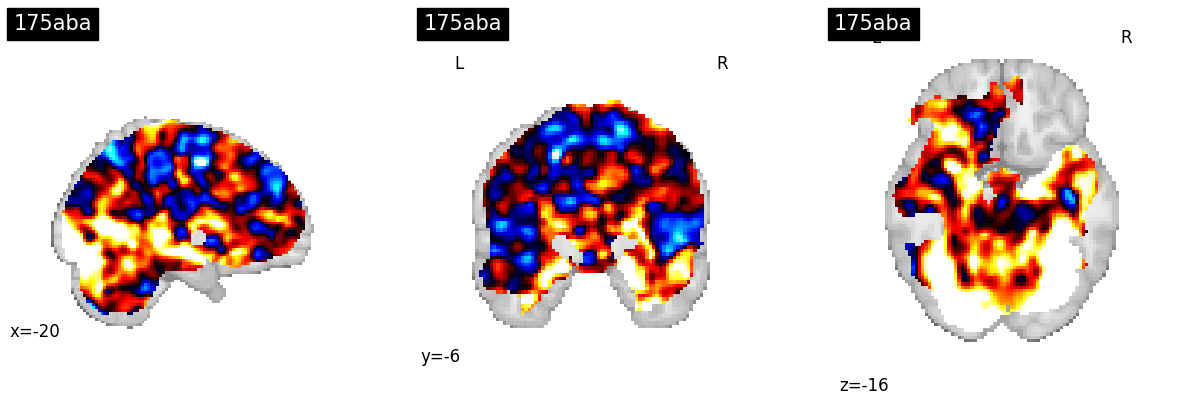

Cluster [2] - Antimedoid


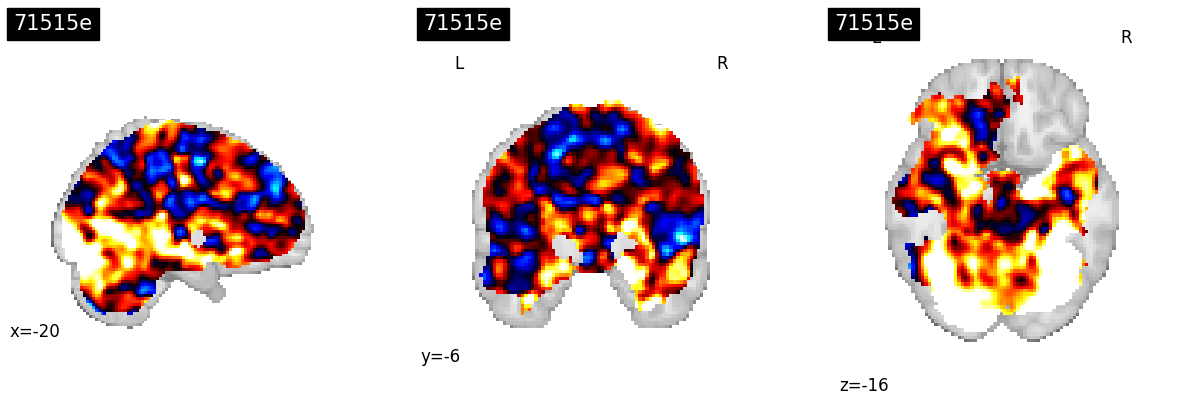

Cluster [3] - Medoid [0299dc9e279b6d0a5010792b7eccf32060d171f94d6dde8285c4e426cfe357e2]


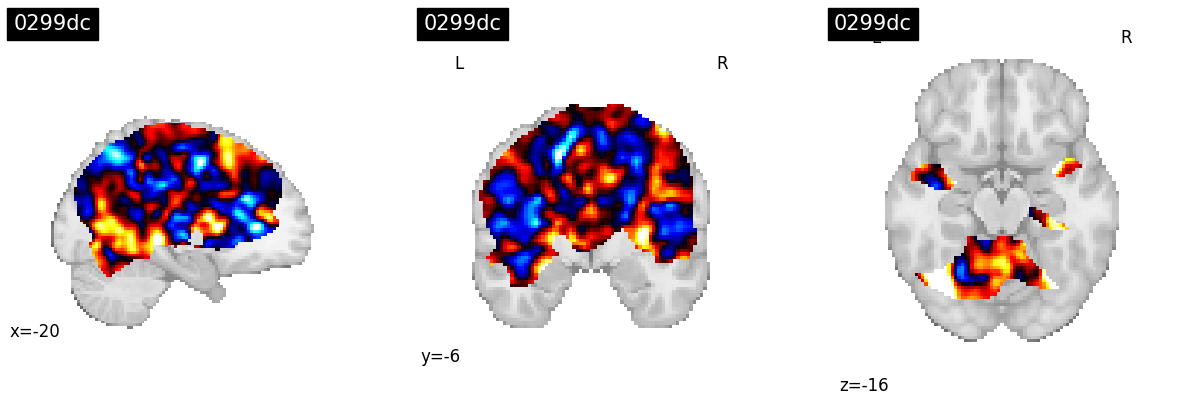

Cluster [3] - Antimedoid


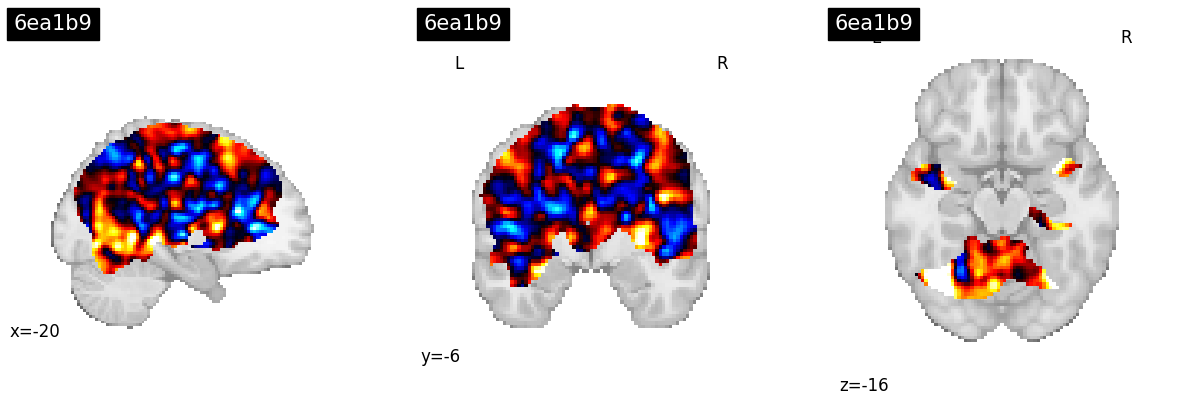

Cluster [4] - Medoid [389ad782a09c22f9e9028ce8f4cc2d6a84301e27847d742e6b31073466cedde6]


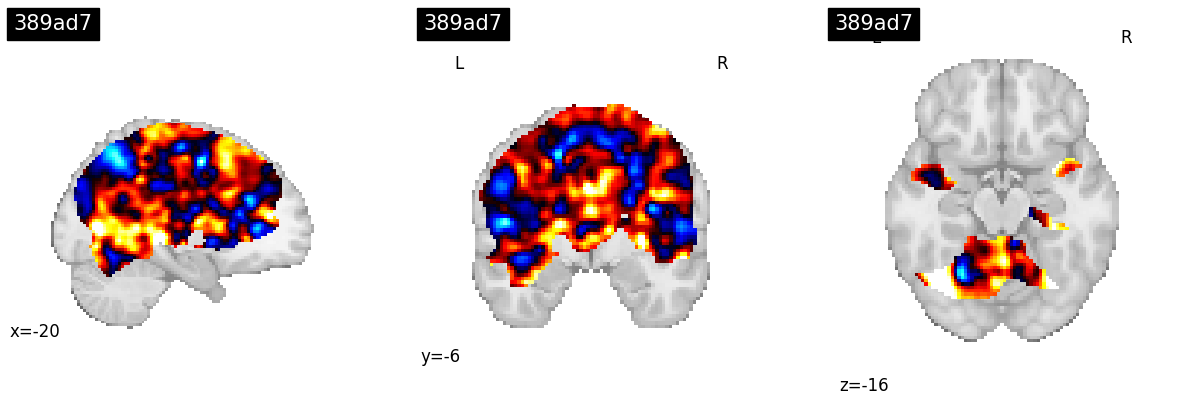

Cluster [4] - Antimedoid


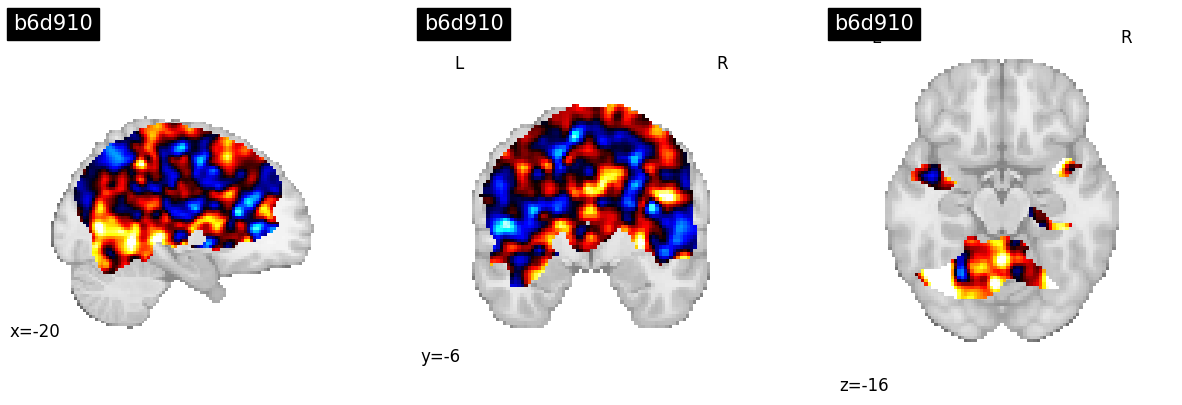

Cluster [5] - Medoid [fa2deb46827075242a1260f6b1197f4c23c8fb5b891cecc1feecbdf1d9917c34]


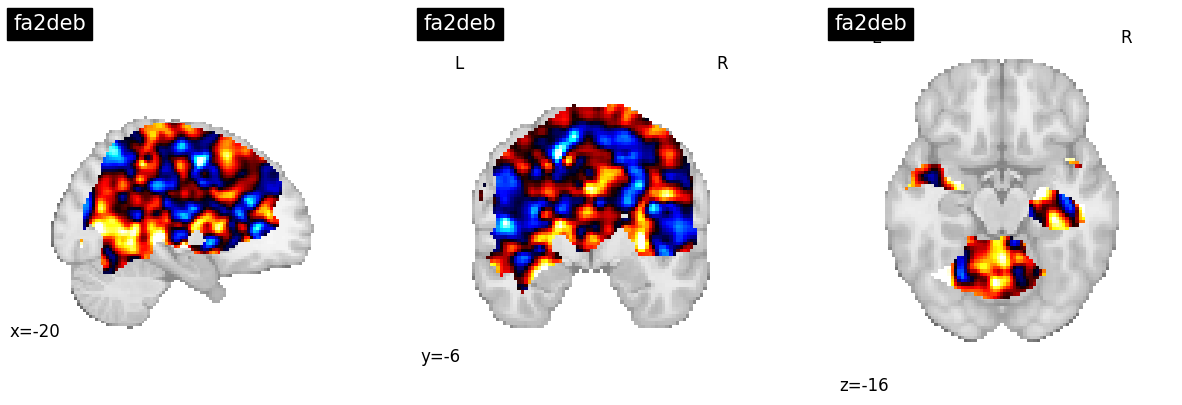

Cluster [5] - Antimedoid


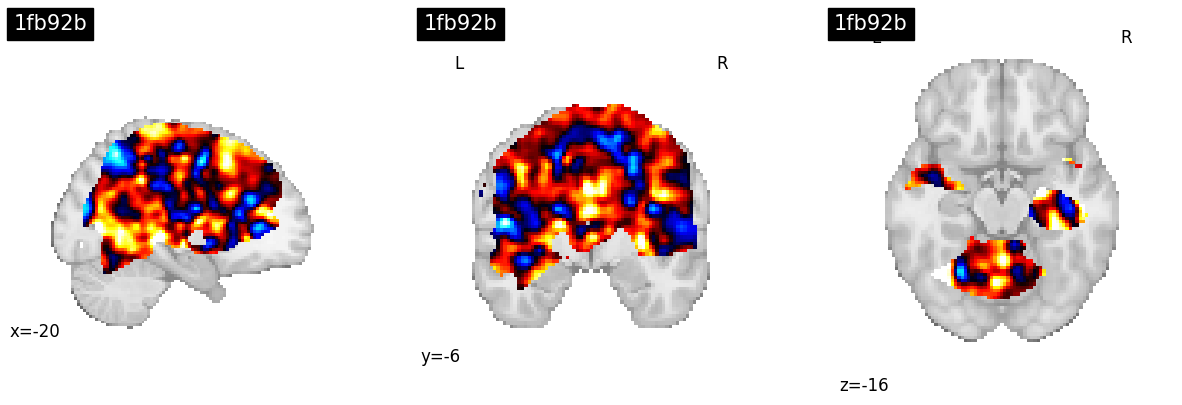

Cluster [6] - Medoid [56747904fbc35abc621f0abc36d1c348d7a34db89a457481777c7149461f9c5b]


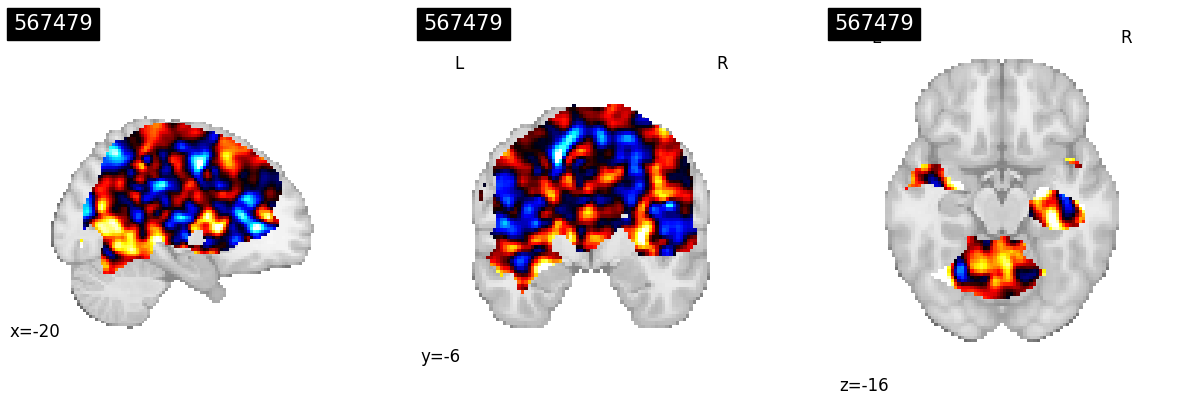

Cluster [6] - Antimedoid


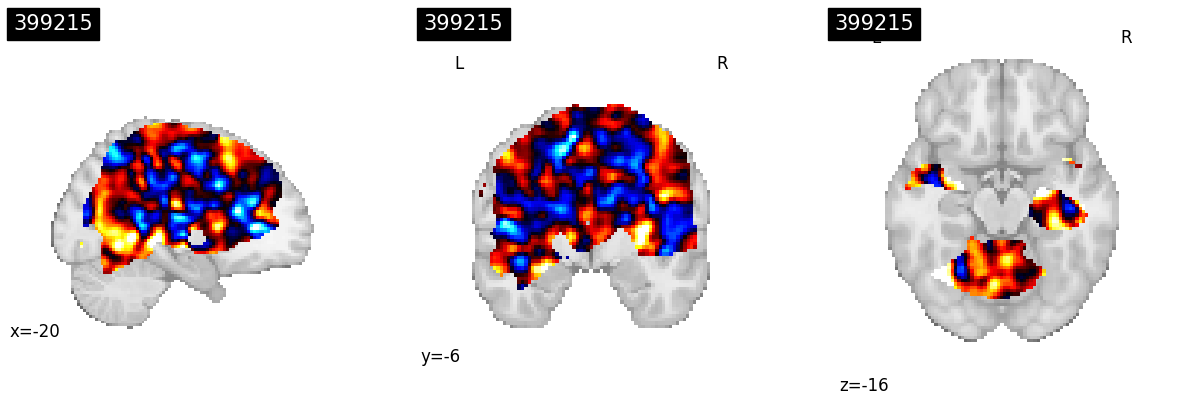

Cluster [7] - Medoid [125dc798401385965e556a03d711af52cb6b10f250a488f6be16c86fe5e78019]


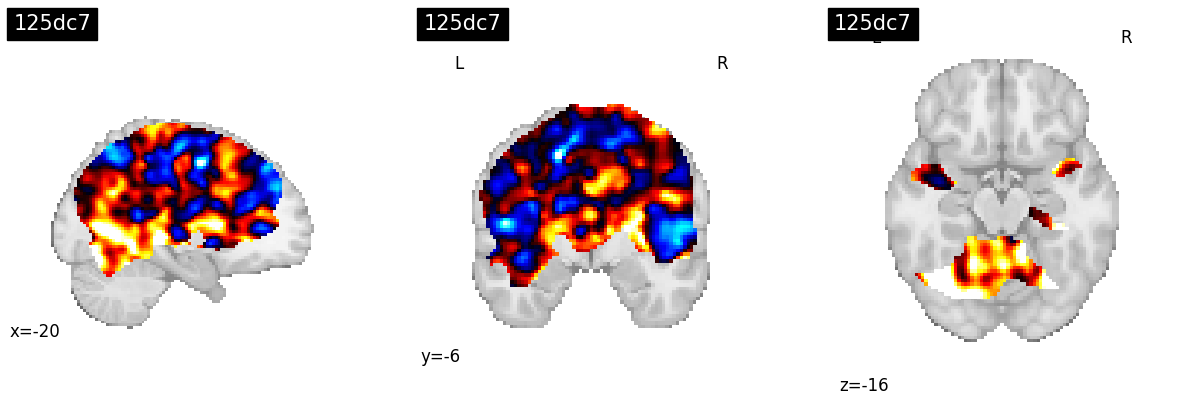

Cluster [7] - Antimedoid


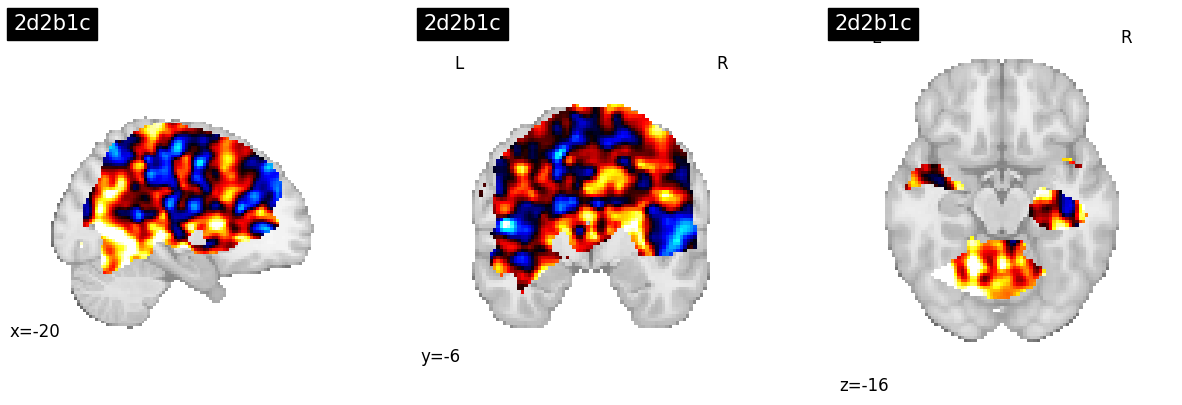

In [37]:
from plot_utils import plot_brain

threshold = 0.20
medoids = df_results.loc[df_results['threshold'] == threshold, 'medoids'].values[0]
medoids = {k: medoids[k] for k in sorted(medoids)}
antimedoids = df_results.loc[df_results['threshold'] == threshold, 'antimedoids'].values[0]
for key, value in medoids.items():
    print(f"Cluster [{key}] - Medoid [{value}]")
    img_path = os.path.join(result_path, value, 'spmT_0001.nii')
    plot_brain(img_path, coords, ref_path=None)
    print(f"Cluster [{key}] - Antimedoid")
    img_path = os.path.join(result_path, antimedoids[key], 'spmT_0001.nii')
    plot_brain(img_path, coords, ref_path=None)

# Filter incorrect configs
- Cluster by t
- Display medoids
- Eliminate cluster by medoids

In [38]:
excluding_medoids = []

for key, value in medoids.items():
    if key not in [1, 2]:
        excluding_medoids.append(value)

print(f"Excludes {len(excluding_medoids)} clusters")

ds, matrix, Z, clusters = clusterize_hierch(dataset, correlations, dataset['id'], None, corr_func, threshold)

print(f"Threshold = {threshold} - Clusters = {len(clusters.unique())}")

clusters_to_exclude = set()
for medoid in excluding_medoids:
    cluster = ds.loc[ds['id'] == medoid, 'cluster'].values
    if len(cluster) > 0:
        clusters_to_exclude.add(cluster[0])

acceptable_dataset = ds[~ds['cluster'].isin(clusters_to_exclude)]
acceptable_dataset = acceptable_dataset.drop(columns=['cluster'])
acceptable_dataset.to_csv(os.path.join(datadir, 'acceptable_dataset.csv'), index=False)
print(f"Acceptabes : {len(acceptable_dataset)}")

unacceptable_dataset = ds[ds['cluster'].isin(clusters_to_exclude)]
unacceptable_dataset = unacceptable_dataset.drop(columns=['cluster'])
unacceptable_dataset.to_csv(os.path.join(datadir, 'unacceptable_dataset.csv'), index=False) 
print(f"Unacceptabes : {len(unacceptable_dataset)}")

filtered_dataset = acceptable_dataset.copy()

Excludes 5 clusters
Threshold = 0.2 - Clusters = 7
Acceptabes : 380
Unacceptabes : 124


In [39]:
# from scipy.cluster.hierarchy import dendrogram
# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA
# 
# # Plot the dendrogram (optional, for visualization)
# plt.figure(figsize=(10, 5))
# dendrogram(Z, truncate_mode='lastp', p=50)  # Show last 50 merges
# plt.title('Dendrogram')
# plt.show()
# 
# # PCA
# distance_matrix = 1 - matrix
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(dataset)
# plt.figure(figsize=(10, 6))
# sb.scatterplot(
#     x=pca_result[:, 0], y=pca_result[:, 1],
#     hue=clusters,
#     palette='tab20',
#     alpha=0.7
# )
# plt.title('PCA Plot of Clusters')
# plt.show()
# 
# # t-SNE
# 
# tsne = TSNE(n_components=2, random_state=42)
# tsne_result = tsne.fit_transform(dataset)
# print(len(tsne_result))

## Distribution from_ref for acceptable/unacceptable

{'min': np.float64(0.7708958826728557), 'max': np.float64(1.0), 'mean': np.float64(0.9002456708658317)}
{'min': np.float64(0.3794136303111239), 'max': np.float64(0.5857264211530007), 'mean': np.float64(0.49401081525364177)}


/home/ymerel/tmp/ipykernel_48689/590727294.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


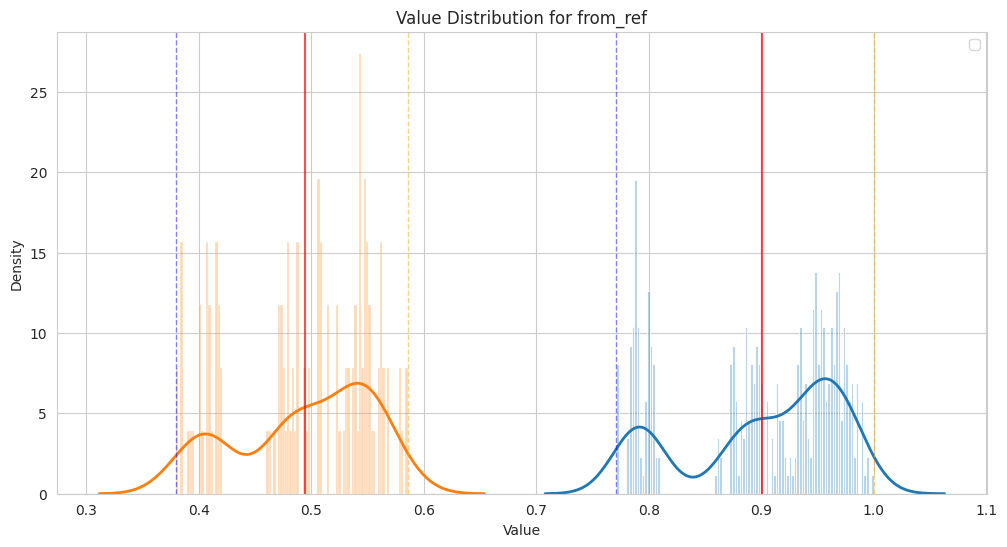

In [40]:
# Create a dictionary to loop over the datasets
datasets = {
    'Acceptable': acceptable_dataset,
    'Unacceptable': unacceptable_dataset
}

# Calculate min, max, and mean for each dataset
stats = {}
for label, df in datasets.items():
    stats[label] = {
        'min': df['from_ref'].min(),
        'max': df['from_ref'].max(),
        'mean': df['from_ref'].mean()
    }
    print(stats[label])

# Plot
plt.figure(figsize=(12, 6))
for label, df in datasets.items():
    sb.histplot(
        df['from_ref'],
        bins=100,
        alpha=0.3,
        label='',
        kde=False,
        stat='density'
    )
    sb.kdeplot(
        df['from_ref'],
        label='',
        linewidth=2
    )
    # Add vertical lines for min, max, and mean
    plt.axvline(stats[label]['min'], color='blue', linestyle='--', alpha=0.5, linewidth=1, label=f'')
    plt.axvline(stats[label]['max'], color='orange', linestyle='--', alpha=0.5, linewidth=1, label=f'')
    plt.axvline(stats[label]['mean'], color='red', linestyle='-', alpha=0.7, linewidth=1.5, label=f'')

plt.title('Value Distribution for from_ref')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

/home/ymerel/tmp/ipykernel_48689/2666558622.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_importances_df, palette='viridis')


accuracy: 1.0 , recall: 1.0


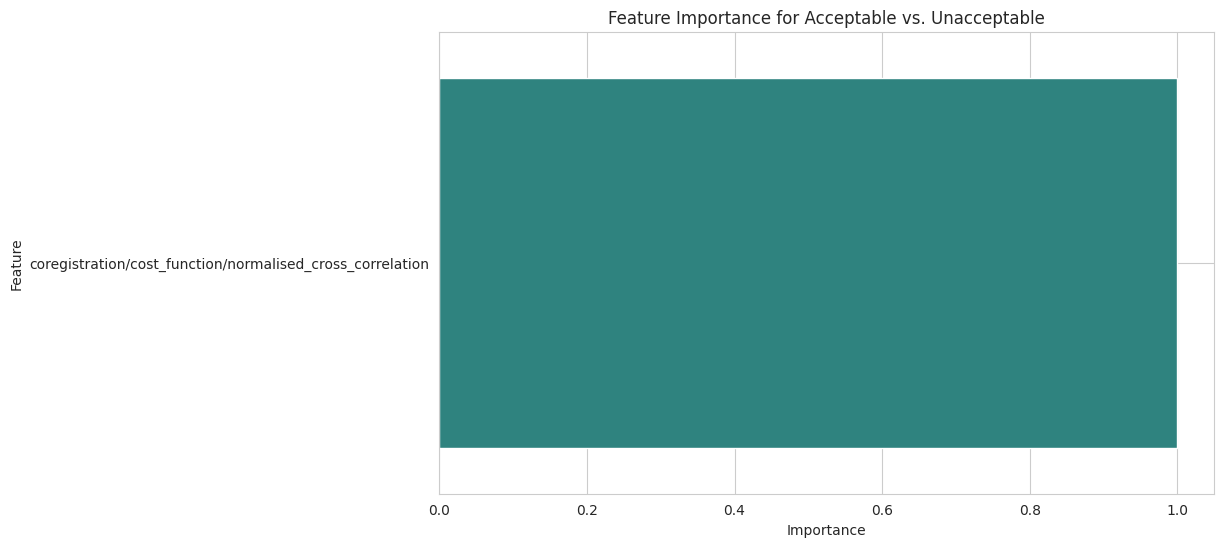

In [41]:
from sklearn import tree
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz


def analyze_feature_importance(acceptable, unacceptable, train_size=0.7):
    # Combine datasets and add a binary target column
    acceptable['target'] = 0  # 0 for acceptable
    unacceptable['target'] = 1  # 1 for unacceptable
    combined = pd.concat([acceptable, unacceptable])

    # Drop non-feature columns (e.g., 'id')
    ignored = [col for col in combined.columns if col.startswith('from_') or col in ['id', 'target']]
    features = combined.drop(columns=ignored).columns
    X = combined[features]
    y = combined['target']

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=42
    )

    # Train a Decision Tree classifier
    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = classifier.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    print(f"accuracy: {report['accuracy']} , recall: {report['macro avg']['recall']}")

    # Extract feature importances
    importances = classifier.feature_importances_
    feat_importances = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    importances = classifier.feature_importances_
    feat_importances = dict()
    for i, feat in enumerate(features):
        if importances[i] > 0.0:
            feat_importances[feat] = importances[i]
    results['feature_importances'] = feat_importances
    
    dot_data = tree.export_graphviz(classifier, out_file=None,
     feature_names=X_train.columns.values,
     filled=True, rounded=True,
     special_characters=True,
     leaves_parallel=True, proportion=True)
    graph = graphviz.Source(dot_data)
    graph.render(f"unacceptable_vs_acceptable")
    
    return feat_importances

feat_importances_df = pd.DataFrame(
    list(analyze_feature_importance(acceptable_dataset, unacceptable_dataset).items()),
    columns=['Feature', 'Importance']
)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances_df, palette='viridis')
plt.title('Feature Importance for Acceptable vs. Unacceptable')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()



## [Filtered] Cluster by threshold

In [42]:
all_results = []

print(len(filtered_dataset))

thresholds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in thresholds:
    results = dict()
    results['threshold'] = threshold
    # cluster on whole dataset
    ds, matrix, Z, clusters =  clusterize_hierch(filtered_dataset, correlations, filtered_dataset['id'], None, corr_func, threshold)
    results['clusters'] = len(np.unique(clusters.values)) 
    
    distance_matrix = 1 - matrix
    densities = get_cluster_distance_densities(distance_matrix.values, clusters.values)
    results['mean_density'] = np.mean(list(densities.values()))
    results['cophenetic'] = get_cluster_cophenetic(Z, distance_matrix.values)
    results['silhouette'] = get_cluster_silhouette(distance_matrix.values, clusters.values)
    results['davies_bouldin'] = get_davies_bouldin(distance_matrix.values, clusters.values)
    results['inertia'] = get_cluster_inertia(distance_matrix.values, clusters.values)
    results['medoids'] = get_medoids(distance_matrix, clusters)
    results['antimedoids'] = get_antimedoids(distance_matrix, clusters)

        
    # predict on 70 % train dataset
    merged_results = results | predict_clusters(filtered_dataset, correlations, None, corr_func, threshold, 0.7)
    all_results.append(merged_results)

df_by_thresh = pd.DataFrame(all_results)
df_results = df_by_thresh
df_by_thresh.head(20)

380


/home/ymerel/fmri/OHBM_2026_neurovariants/utils.py:110: RuntimeWarning: invalid value encountered in scalar divide
  avg_dist = (np.sum(cluster_dist) - np.sum(np.diag(cluster_dist))) / (cluster_dist.size - len(cluster_dist))
/home/ymerel/fmri/OHBM_2026_neurovariants/utils.py:110: RuntimeWarning: invalid value encountered in scalar divide
  avg_dist = (np.sum(cluster_dist) - np.sum(np.diag(cluster_dist))) / (cluster_dist.size - len(cluster_dist))
/home/ymerel/fmri/OHBM_2026_neurovariants/utils.py:110: RuntimeWarning: invalid value encountered in scalar divide
  avg_dist = (np.sum(cluster_dist) - np.sum(np.diag(cluster_dist))) / (cluster_dist.size - len(cluster_dist))


,threshold,clusters,mean_density,cophenetic,silhouette,davies_bouldin,inertia,medoids,antimedoids,train_size,accuracy,recall,decision_tree,feature_importances
0,0.01,135,NaN,0.939263,0.459412,0.659195,0.036502,{110: '006fb38da122f3aa516a611c695294f915f1508...,{110: '006fb38da122f3aa516a611c695294f915f1508...,0.7,0.561404,0.359966,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.0202...
1,0.02,65,NaN,0.939263,0.480426,0.861970,0.379436,{51: '006fb38da122f3aa516a611c695294f915f1508f...,{51: '16590aa85c2c15a26349366876c38361091f5aca...,0.7,0.833333,0.618333,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.0533...
2,0.03,42,NaN,0.939263,0.486723,0.797831,0.828814,{32: '006fb38da122f3aa516a611c695294f915f1508f...,{32: '16590aa85c2c15a26349366876c38361091f5aca...,0.7,0.912281,0.769820,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.0592...
3,0.04,24,0.017096,0.939263,0.476787,0.898911,3.355147,{14: '4a2c7f224d52d32e04f2caac6cef43a76ee5bc3e...,{14: '006fb38da122f3aa516a611c695294f915f1508f...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.1138...
4,0.05,15,0.021368,0.939263,0.516133,1.010225,9.958221,{8: '8e7a3fb09a6004de3f0afe2851c25be3282d4b51f...,{8: '73f58b4b40fd50331130902dbdf5c93307cb88890...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.2212...
5,0.10,4,0.035529,0.939263,0.550022,0.799056,61.457301,{1: 'b10ba27b41c72cecd805fe36c225741ff4fd50f1f...,{1: 'f16d9fe0be02758f93babb75adea3d1ecb0129bc9...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors/motion':...
6,0.15,3,0.038439,0.939263,0.637069,0.433531,134.049269,{1: 'b10ba27b41c72cecd805fe36c225741ff4fd50f1f...,{1: '3a9f642fc69e25b0249c29200e88afa8956cd7285...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors/motion':...
7,0.20,2,0.050077,0.939263,0.625280,0.350500,618.355716,{1: '39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c...,{1: '8b0536ff1f27f2ac4767ba4a610e6b6acaf3f3193...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 1.0}
8,0.25,1,0.110483,0.939263,NaN,NaN,2294.246795,{1: '63669d11fdc934c5bd51d71bcfbdcf8bd57e1f9d8...,{1: '71515e9aa18d9e5a3982b2c804496dc4317fe6c56...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{}
9,0.30,1,0.110483,0.939263,NaN,NaN,2294.246795,{1: '63669d11fdc934c5bd51d71bcfbdcf8bd57e1f9d8...,{1: '71515e9aa18d9e5a3982b2c804496dc4317fe6c56...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{}


## [Filtered] Print all metrics
- Cophenetic correlation: > 0.75 = good ; < 0.75 = poor
- Silhouette score: -1 = worst ; 1 = best
- Davies-Bouldin index: < 1 = good
- Inertia: lower = tighter

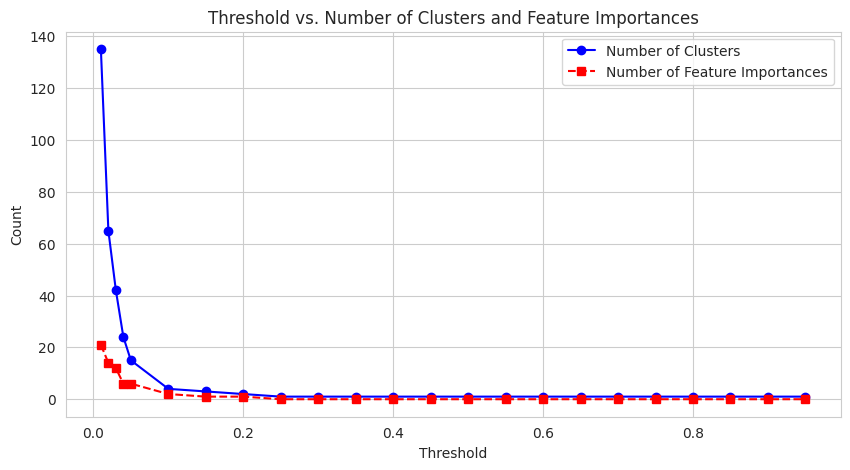

In [43]:
import matplotlib.pyplot as plt

# Add a new column to count the number of feature importances for each threshold
df_results['num_feature_importances'] = df_results['feature_importances'].apply(lambda x: len(x))

# Plot threshold vs. number of clusters
plt.figure(figsize=(10, 5))
plt.plot(df_results['threshold'], df_results['clusters'], marker='o', linestyle='-', color='b', label='Number of Clusters')

# Plot threshold vs. number of feature importances
plt.plot(df_results['threshold'], df_results['num_feature_importances'], marker='s', linestyle='--', color='r', label='Number of Feature Importances')

plt.title('Threshold vs. Number of Clusters and Feature Importances')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.show()

# [Filtered] Feature importances

/home/ymerel/tmp/ipykernel_48689/271901642.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=feat_importances_df, palette='viridis')


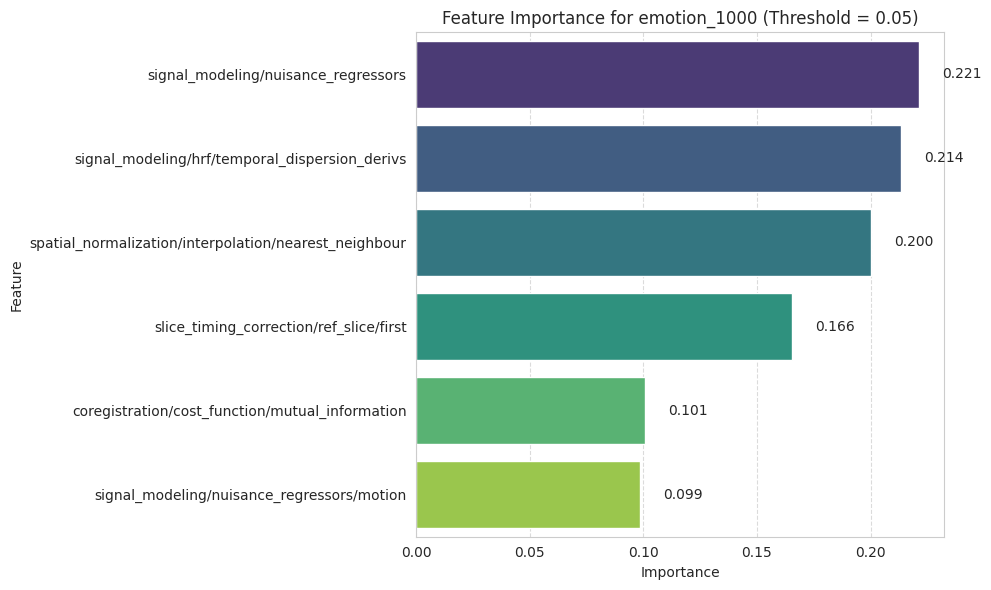

In [54]:
import pandas as pd1
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

threshold=0.05

# Extract feature importances for threshold == 0.10
feat_importances_dict = df_results.loc[df_results['threshold'] == threshold, 'feature_importances'].values[0]

# Convert to DataFrame and sort by importance (descending)
feat_importances_df = pd.DataFrame(
    list(feat_importances_dict.items()),
    columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=False)

# Render decision tree
graph = graphviz.Source(df_results.loc[df_results['threshold'] == threshold, 'decision_tree'].values[0])

graph.render(f"emotion")

# Plot feature importances
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Feature', data=feat_importances_df, palette='viridis')

# Display the importance values on the bars
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.01,  # x position (slightly right of the bar)
             p.get_y() + p.get_height() / 2,  # y position (center of the bar)
             f'{width:.3f}',  # text to display (formatted to 3 decimal places)
             ha='left',  # horizontal alignment
             va='center')  # vertical alignment

plt.title(f'Feature Importance for {jobname} (Threshold = {threshold})')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Cluster [1] - Medoid [b10ba27b41c72cecd805fe36c225741ff4fd50f1f9f734d027a7de9a13d74ad5] - Correlation to ref [0.989591569466676] - Mean activation [0.5843]


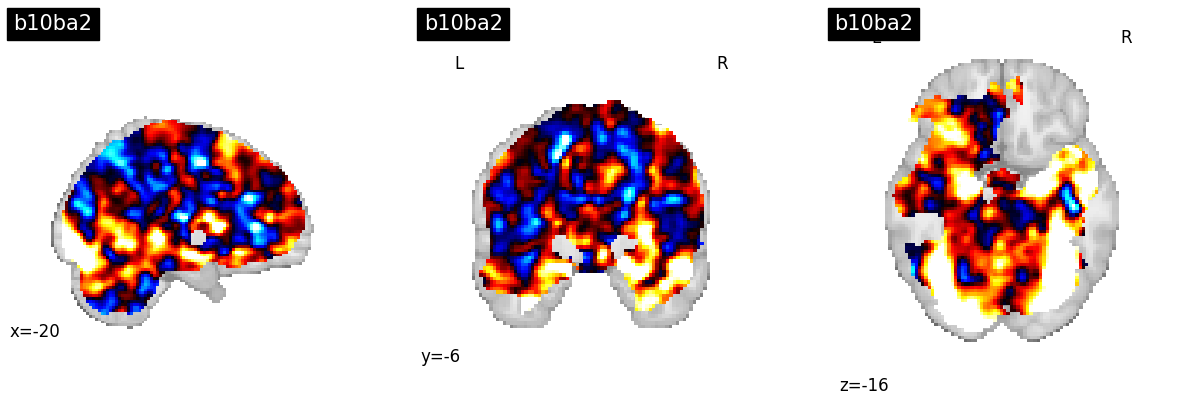

Cluster [1] - Antimedoid


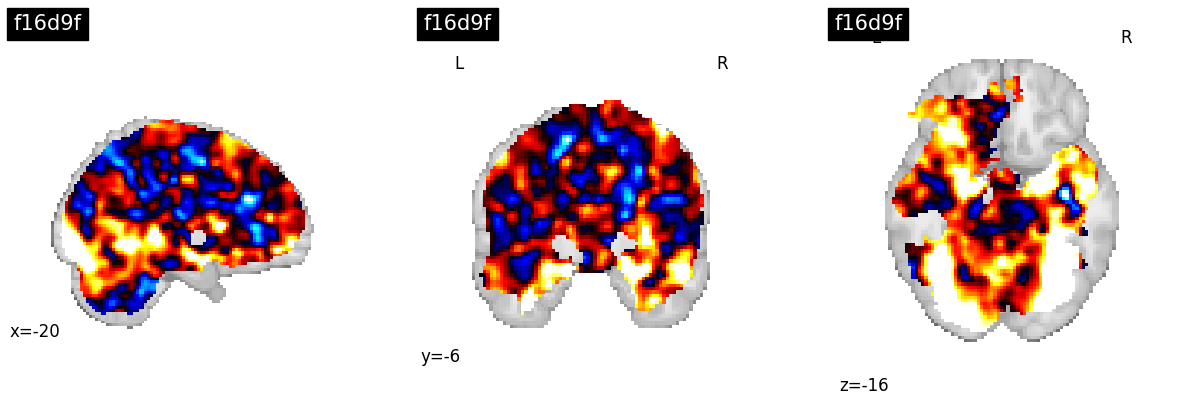

Cluster [2] - Medoid [9111a94c1a55f876b2a92dfa6466af0879e5b3487240c5ebf816502c3366b1d5] - Correlation to ref [0.8976146131360991] - Mean activation [0.8420]


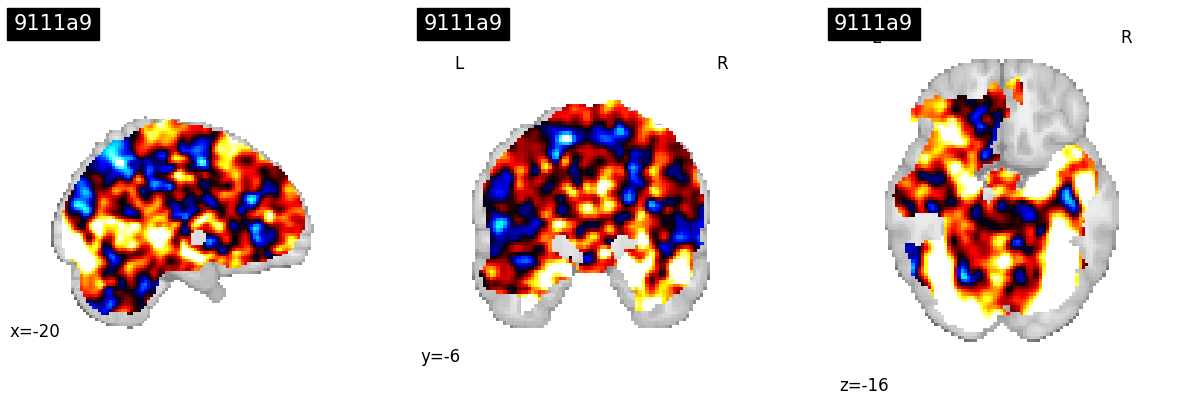

Cluster [2] - Antimedoid


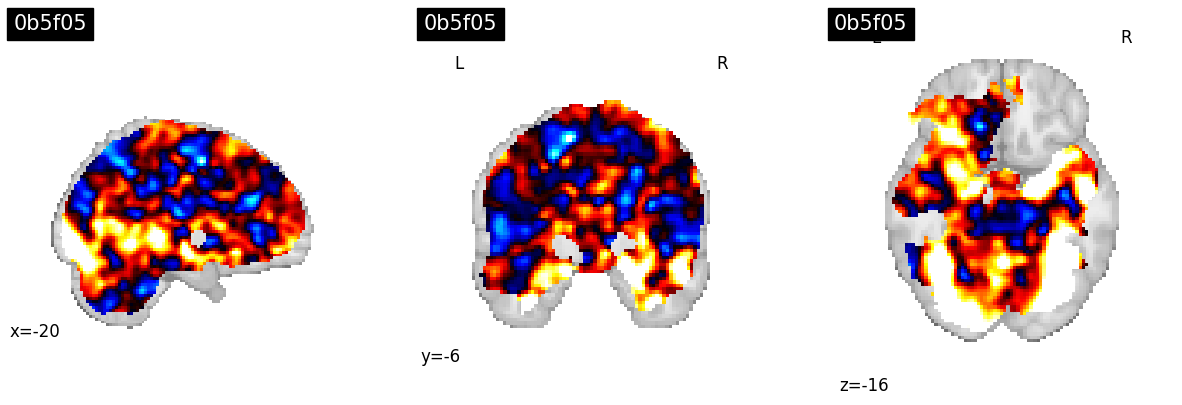

Cluster [3] - Medoid [bd38bf68c4610266db4c0ba6041ca72fb8bf251ba4d76455b42b7ae84d8fd4a5] - Correlation to ref [0.9613514024880336] - Mean activation [0.6478]


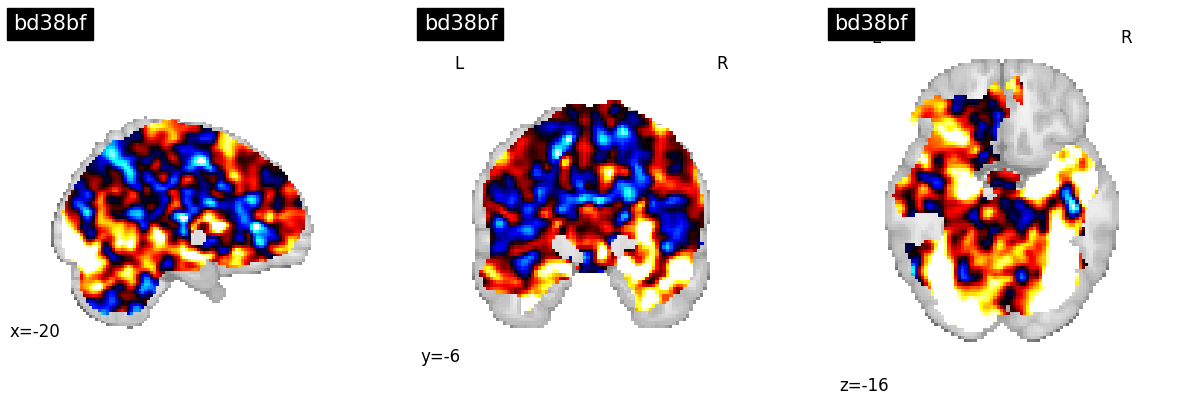

Cluster [3] - Antimedoid


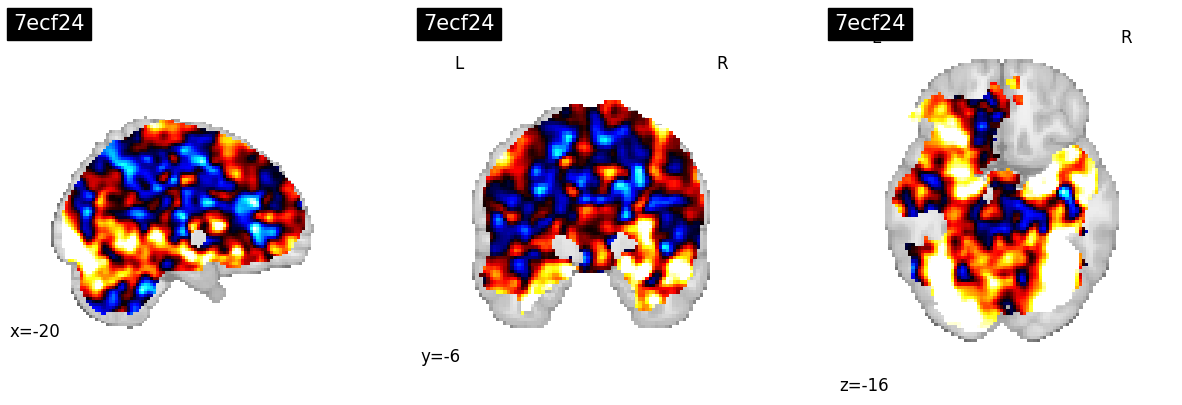

Cluster [4] - Medoid [175aba5e213089daa24c32d5cb3c34193538db2a394fe7956eec838c924b11d5] - Correlation to ref [0.8054114068167737] - Mean activation [0.7661]


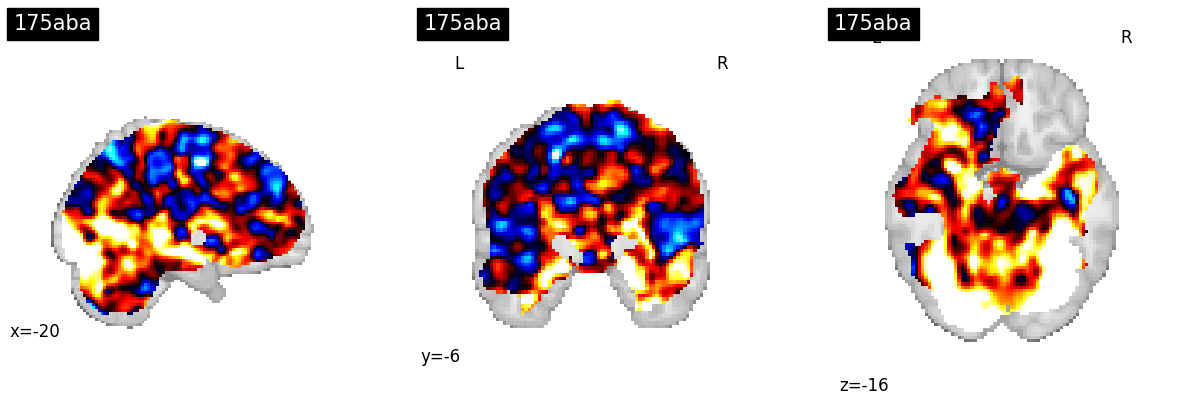

Cluster [4] - Antimedoid


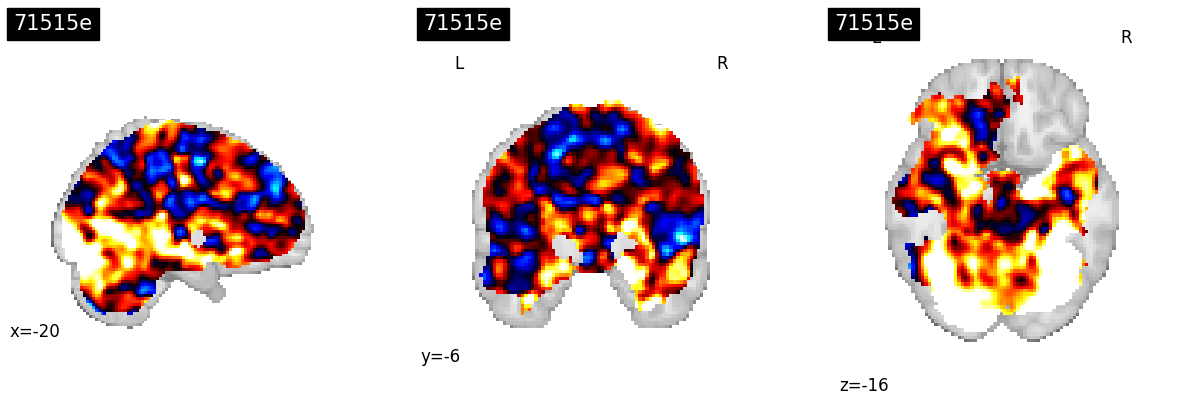

In [53]:
from plot_utils import plot_brain
import nilearn.image as nimg

medoids = df_results.loc[df_results['threshold'] == threshold, 'medoids'].values[0]
medoids = {k: medoids[k] for k in sorted(medoids)}
antimedoids = df_results.loc[df_results['threshold'] == threshold, 'antimedoids'].values[0]
for key, value in medoids.items():
    img_path = os.path.join(result_path, value, 'spmT_0001.nii')
    img = nimg.load_img(img_path)
    activation_values = img.get_fdata().ravel()  # Flatten the 3D volume into a 1D array
    activation_values = activation_values[~np.isnan(activation_values)]
    activation_values = activation_values[activation_values != 0]
    mean_activation = np.mean(activation_values)
    print(f"Cluster [{key}] - Medoid [{value}] - Correlation to ref [{dataset.loc[dataset['id'] == value, 'from_ref'].values[0]}] - Mean activation [{mean_activation:.4f}]")
    plot_brain(img_path, coords, ref_path=None)
    print(f"Cluster [{key}] - Antimedoid")
    img_path = os.path.join(result_path, antimedoids[key], 'spmT_0001.nii')
    plot_brain(img_path, coords, ref_path=None)

In [50]:
import pydot

# Extract the DOT source from the graphviz.Source object
dot_source = graph.source
# Load the DOT source into pydot
graph_pydot = pydot.graph_from_dot_data(dot_source)[0]
for node in graph_pydot.get_nodes():
    print(node.get_sequence())
    node.get_port()
for edge in graph_pydot.get_edges():
    print(edge)

1
2
3
4
5
7
9
11
13
15
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"];
1 -> 2;
1 -> 3;
0 -> 4 [labeldistance=2.5, labelangle="-45", headlabel="False"];
4 -> 5;
4 -> 6;
